#Week 08 Keras DNN Implementations Lab

Reference: Textbook Chapter 10 & 11

##Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Building an Image Classifier

First let's import TensorFlow and Keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
#Loading the dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [ ]:
# splitting the full training set into a validation set and a (smaller) training set
# scaling the pixel intensities down to the 0-1 range
# and converting them to floats, by dividing by 255
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

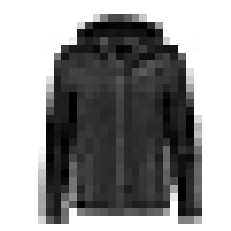

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train #array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

'Coat'

Let's take a look at a sample of the images in the dataset:

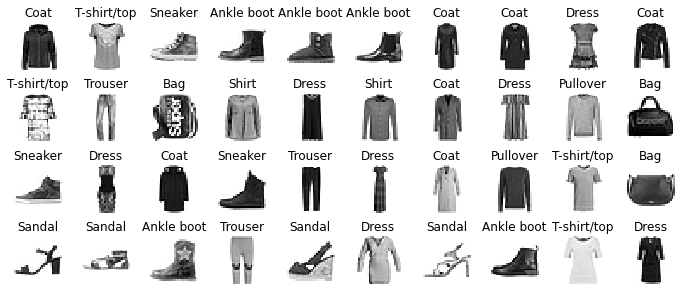

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Creaing the model using the Sequential API

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# option1: creat model by adding layers one by one
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
# option2: creat model as a whole
# the two options are equivalent
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


Compliling the model

In [ ]:
# to see what args can be tuned when compiling a model, checkout https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

Training and evaluating the model

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 3ms/step - loss: 0.7691 - accuracy: 0.7444 - val_loss: 0.5401 - val_accuracy: 0.8120
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5019 - accuracy: 0.8221 - val_loss: 0.4489 - val_accuracy: 0.8462
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4549 - accuracy: 0.8393 - val_loss: 0.5761 - val_accuracy: 0.7846
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4282 - accuracy: 0.8505 - val_loss: 0.4070 - val_accuracy: 0.8594
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4100 - accuracy: 0.8573 - val_loss: 0.3899 - val_accuracy: 0.8618
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3916 - accuracy: 0.8631 - val_loss: 0.3836 - val_accuracy: 0.8682
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3796 - accuracy: 0.8669 - val_loss: 0.3751 - val_accuracy:

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


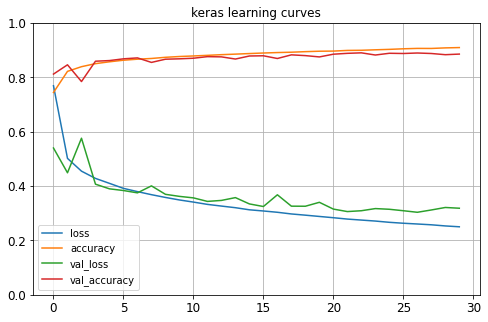

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()

In [ ]:
# measure how well the model perform on the test set
# test_loss and test_accuracy
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3525 - accuracy: 0.8732


[0.3525136113166809, 0.873199999332428]

# Building the model 1
- Activation function: Sigmoid
- Optimization: SGD
- Architecture: 10\*20\*30\*50\*10
- Initialization: Norm 

Epoch 1/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3059 - accuracy: 0.0992 - val_loss: 2.3042 - val_accuracy: 0.1008
Epoch 2/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3037 - accuracy: 0.0978 - val_loss: 2.3037 - val_accuracy: 0.0976
Epoch 3/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3037 - accuracy: 0.0984 - val_loss: 2.3059 - val_accuracy: 0.0986
Epoch 4/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3036 - accuracy: 0.1007 - val_loss: 2.3023 - val_accuracy: 0.0986
Epoch 5/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3036 - accuracy: 0.0983 - val_loss: 2.3044 - val_accuracy: 0.0986
Epoch 6/50
1719/1719 [==============================] - 6s 3ms/step - loss: 2.3035 - accuracy: 0.0981 - val_loss: 2.3037 - val_accuracy: 0.0980
Epoch 7/50
1719/1719 [==============================] - 5s 3ms/step - loss: 2.3033 - accuracy: 0.1033 - val_loss: 2.3034 - val_accuracy:

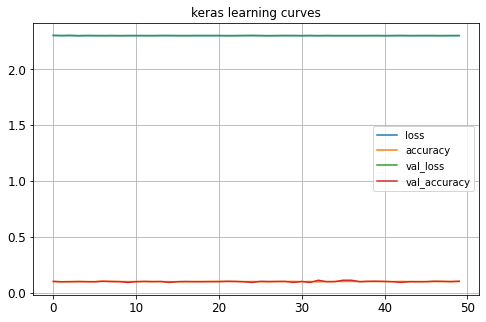

313/313 [==============================] - 1s 2ms/step - loss: 2.3031 - accuracy: 0.1000
[2.3031206130981445, 0.10000000149011612]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(10, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(20, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(30, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(50, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 dense_3 (Dense)             (None, 50)                1550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
Total params: 10,760
Trainable params: 10,760
Non-traina

# Building the model 2
- Activation function: Sigmoid
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Norm 

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 2.2058 - accuracy: 0.3009 - val_loss: 2.0182 - val_accuracy: 0.4500
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.7351 - accuracy: 0.4853 - val_loss: 1.4886 - val_accuracy: 0.5400
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3421 - accuracy: 0.5829 - val_loss: 1.2039 - val_accuracy: 0.6402
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1203 - accuracy: 0.6266 - val_loss: 1.0336 - val_accuracy: 0.6490
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9852 - accuracy: 0.6610 - val_loss: 0.9255 - val_accuracy: 0.7002
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8883 - accuracy: 0.6979 - val_loss: 0.8407 - val_accuracy: 0.7254
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8139 - accuracy: 0.7204 - val_loss: 0.7747 - val_accuracy:

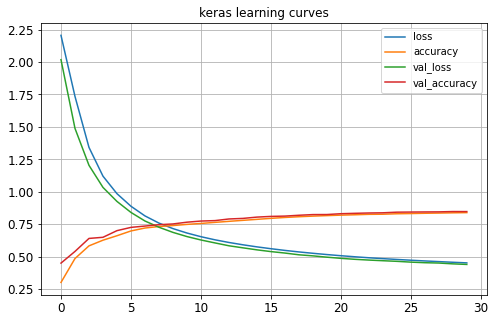

313/313 [==============================] - 1s 2ms/step - loss: 0.4797 - accuracy: 0.8269
[0.47967538237571716, 0.8269000053405762]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(50, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


# Building the model 3
- Activation function: ReLU
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Norm 

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1719/1719 [==============================] - 5s 3ms/step - loss: 0.9361 - accuracy: 0.6918 - val_loss: 0.5740 - val_accuracy: 0.8024
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5363 - accuracy: 0.8119 - val_loss: 0.5060 - val_accuracy: 0.8232
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4799 - accuracy: 0.8309 - val_loss: 0.4526 - val_accuracy: 0.8416
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4508 - accuracy: 0.8420 - val_loss: 0.4301 - val_accuracy: 0.8522
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4319 - accuracy: 0.8498 - val_loss: 0.4098 - val_accuracy: 0.8564
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4160 - accuracy: 0.8538 - val_loss: 0.4013 - val_accuracy: 0.8660
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4022 - accuracy: 0.8587 - val_loss: 0.3832 - val_accuracy: 0.8698
Epo

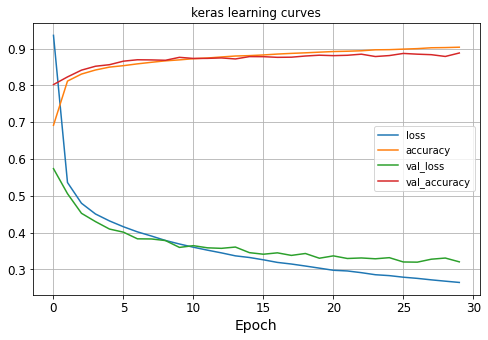

313/313 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.8782
[0.3467042148113251, 0.8781999945640564]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(50, activation="relu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.xlabel('Epoch')
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 4
- Activation function: Sigmoid
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Xavier 

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="sigmoid", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(50, activation="sigmoid", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 2.1014 - accuracy: 0.3700 - val_loss: 1.7861 - val_accuracy: 0.5148
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.5231 - accuracy: 0.5629 - val_loss: 1.2999 - val_accuracy: 0.6356
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1732 - accuracy: 0.6423 - val_loss: 1.0526 - val_accuracy: 0.6822
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9804 - accuracy: 0.6849 - val_loss: 0.9011 - val_accuracy: 0.7166
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8573 - accuracy: 0.7132 - val_loss: 0.8007 - val_accuracy: 0.7438
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7728 - accuracy: 0.7316 - val_loss: 0.7302 - val_accuracy: 0.7496
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7140 - accuracy: 0.7443 - val_loss: 0.6783 - val_accuracy:

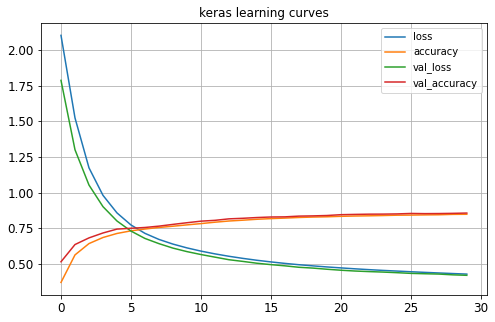

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4588 - accuracy: 0.8333


[0.45876073837280273, 0.833299994468689]

# Building the model 5
- Activation function: ReLU
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Xavier 

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7700 - accuracy: 0.7464 - val_loss: 0.5421 - val_accuracy: 0.8148
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5068 - accuracy: 0.8222 - val_loss: 0.4514 - val_accuracy: 0.8414
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4581 - accuracy: 0.8381 - val_loss: 0.5640 - val_accuracy: 0.7910
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4297 - accuracy: 0.8495 - val_loss: 0.4096 - val_accuracy: 0.8570
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4105 - accuracy: 0.8557 - val_loss: 0.3907 - val_accuracy: 0.8612
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3921 - accuracy: 0.8621 - val_loss: 0.3819 - val_accuracy: 0.8722
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3800 - accuracy: 0.8654 - val_loss: 0.3806 - val_accuracy:

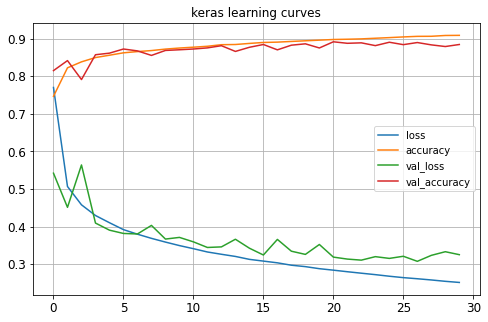

313/313 [==============================] - 1s 2ms/step - loss: 0.3552 - accuracy: 0.8746
[0.3551734983921051, 0.8745999932289124]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 6
- Activation function: ReLU
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: he_normal

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7326 - accuracy: 0.7570 - val_loss: 0.5292 - val_accuracy: 0.8184
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4952 - accuracy: 0.8264 - val_loss: 0.4395 - val_accuracy: 0.8496
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4482 - accuracy: 0.8425 - val_loss: 0.5272 - val_accuracy: 0.8044
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4210 - accuracy: 0.8539 - val_loss: 0.3993 - val_accuracy: 0.8630
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4029 - accuracy: 0.8587 - val_loss: 0.3841 - val_accuracy: 0.8654
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3854 - accuracy: 0.8648 - val_loss: 0.3767 - val_accuracy: 0.8718
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3740 - accuracy: 0.8683 - val_loss: 0.3732 - val_accuracy:

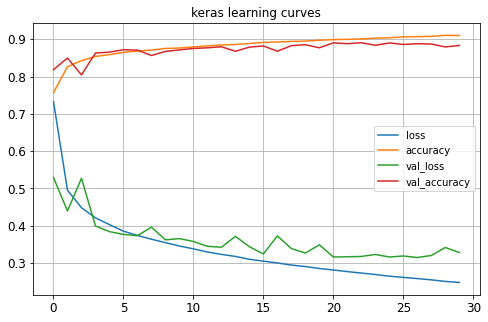

313/313 [==============================] - 1s 2ms/step - loss: 0.3597 - accuracy: 0.8753
[0.35974857211112976, 0.8752999901771545]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 7
- Activation function: ReLU
- Optimization: Mom
- Architecture: 100\*50\*10
- Initialization: He

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7418 - accuracy: 0.7546 - val_loss: 0.5113 - val_accuracy: 0.8250
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4925 - accuracy: 0.8286 - val_loss: 0.4676 - val_accuracy: 0.8414
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4459 - accuracy: 0.8431 - val_loss: 0.4196 - val_accuracy: 0.8518
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4186 - accuracy: 0.8537 - val_loss: 0.4027 - val_accuracy: 0.8614
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4012 - accuracy: 0.8600 - val_loss: 0.3827 - val_accuracy: 0.8656
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3865 - accuracy: 0.8645 - val_loss: 0.3763 - val_accuracy: 0.8732
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3745 - accuracy: 0.8689 - val_loss: 0.3626 - val_accuracy:

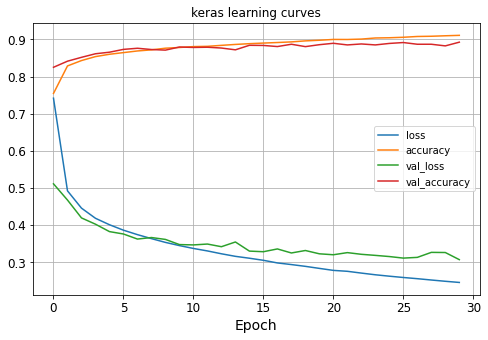

313/313 [==============================] - 1s 2ms/step - loss: 0.3417 - accuracy: 0.8820
[0.3416570723056793, 0.8820000290870667]


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.xlabel('Epoch')
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 8
- Activation function: ReLU
- Optimization: Mom
- Architecture: 100\*50\*10
- Initialization: He
- Epoch: 100

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7418 - accuracy: 0.7546 - val_loss: 0.5113 - val_accuracy: 0.8250
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4925 - accuracy: 0.8287 - val_loss: 0.4677 - val_accuracy: 0.8422
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4459 - accuracy: 0.8431 - val_loss: 0.4198 - val_accuracy: 0.8518
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4186 - accuracy: 0.8538 - val_loss: 0.4027 - val_accuracy: 0.8600
Epoch 5/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4014 - accuracy: 0.8598 - val_loss: 0.3831 - val_accuracy: 0.8646
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3867 - accuracy: 0.8637 - val_loss: 0.3759 - val_accuracy: 0.8736
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3749 - accuracy: 0.8680 - val_loss: 0.3630 - val_ac

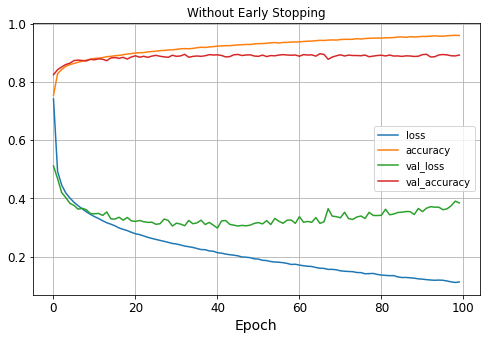

313/313 [==============================] - 1s 2ms/step - loss: 0.4254 - accuracy: 0.8829
[0.42536088824272156, 0.8828999996185303]


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("Without Early Stopping")
plt.xlabel('Epoch')
plt.show()

print(model.evaluate(X_test, y_test))

# Building the model 9
- Activation function: ReLU
- Optimization: Mom
- Architecture: 100\*50\*10
- Initialization: He
- Early Stopping

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7418 - accuracy: 0.7546 - val_loss: 0.5113 - val_accuracy: 0.8250
Epoch 2/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4925 - accuracy: 0.8286 - val_loss: 0.4676 - val_accuracy: 0.8414
Epoch 3/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4458 - accuracy: 0.8431 - val_loss: 0.4194 - val_accuracy: 0.8522
Epoch 4/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4186 - accuracy: 0.8536 - val_loss: 0.4025 - val_accuracy: 0.8598
Epoch 5/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4012 - accuracy: 0.8601 - val_loss: 0.3834 - val_accuracy: 0.8654
Epoch 6/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3865 - accuracy: 0.8642 - val_loss: 0.3756 - val_accuracy: 0.8740
Epoch 7/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3745 - accuracy: 0.8686 - val_loss: 0.3627 - val_accuracy:

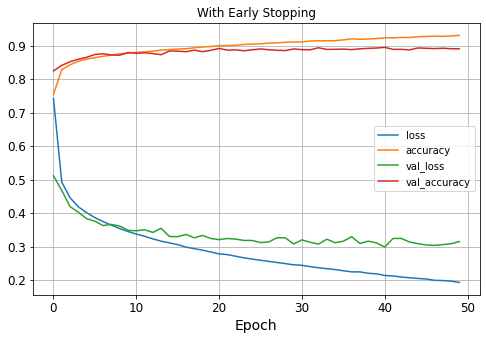

313/313 [==============================] - 1s 2ms/step - loss: 0.3560 - accuracy: 0.8795
[0.3560029864311218, 0.8794999718666077]


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("With Early Stopping")
plt.xlabel('Epoch')
plt.show()

print(model.evaluate(X_test, y_test))

# Hyperparameter Tuning

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def create_model(units=10):
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[28, 28]))
  model.add(keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'))
  model.add(keras.layers.Dense(units=units, activation="relu", kernel_initializer='he_normal'))
  model.add(keras.layers.Dense(10, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])
  return model

model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,epochs=30)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "units": [30, 50, 100, 150, 200]
}

grid_cv = GridSearchCV(model, param_grid, cv=3, verbose=2)
grid_cv.fit(X_valid, y_valid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 2.0484 - accuracy: 0.2955
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.3698 - accuracy: 0.6013
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9779 - accuracy: 0.6940
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8312 - accuracy: 0.7279
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7491 - accuracy: 0.7549
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.7642
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.7828
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.7951
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.8086
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.8137
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 2.0209 - accuracy: 0.3297
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.3114 - accuracy: 0.6286
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9462 - accuracy: 0.6973
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8042 - accuracy: 0.7189
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.7537
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.7759
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.7942
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5933 - accuracy: 0.7981
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5710 - accuracy: 0.8128
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5449 - accuracy: 0.8215
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
105/105 [==============================] - 1s 3ms/step - loss: 1.8409 - accuracy: 0.3914
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.1723 - accuracy: 0.6434
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9252 - accuracy: 0.6938
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8057 - accuracy: 0.7346
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7333 - accuracy: 0.7606
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.7729
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.7870
Epoch 8/30
105/105 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.7936
Epoch 9/30
105/105 [==============================] - 0s 4ms/step - loss: 0.5882 - accuracy: 0.8071
Epoch 10/30
105/105 [==============================] - 0s 4ms/step - loss: 0.5695 - accuracy: 0.8098

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.8409 - accuracy: 0.4005
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.1215 - accuracy: 0.6679
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8515 - accuracy: 0.7171
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7476 - accuracy: 0.7522
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.7702
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.7831
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.7927
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5767 - accuracy: 0.8083
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5575 - accuracy: 0.8164
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5338 - accuracy: 0.8251
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.6479 - accuracy: 0.4800
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0052 - accuracy: 0.6826
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8108 - accuracy: 0.7405
Epoch 4/30
105/105 [==============================] - 0s 2ms/step - loss: 0.7253 - accuracy: 0.7651
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.7834
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.7960
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5931 - accuracy: 0.8044
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5596 - accuracy: 0.8107
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5414 - accuracy: 0.8221
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5149 - accuracy: 0.8317
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.8194 - accuracy: 0.3893
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.1692 - accuracy: 0.6392
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9277 - accuracy: 0.6935
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8108 - accuracy: 0.7340
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7364 - accuracy: 0.7519
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.7705
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.7855
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6161 - accuracy: 0.7918
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5916 - accuracy: 0.8056
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.8107
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.8093 - accuracy: 0.4359
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0559 - accuracy: 0.6823
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8237 - accuracy: 0.7375
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7362 - accuracy: 0.7579
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.7849
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.7822
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.8011
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5769 - accuracy: 0.8137
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5598 - accuracy: 0.8245
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5389 - accuracy: 0.8284
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.8124 - accuracy: 0.4446
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0671 - accuracy: 0.6901
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8222 - accuracy: 0.7453
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.7672
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.7894
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.8020
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.8035
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5548 - accuracy: 0.8158
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5330 - accuracy: 0.8248
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5097 - accuracy: 0.8329
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.7551 - accuracy: 0.4406
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0448 - accuracy: 0.6764
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8328 - accuracy: 0.7262
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7340 - accuracy: 0.7642
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.7720
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.7837
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.7969
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5746 - accuracy: 0.8056
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.8197
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5377 - accuracy: 0.8158
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.7445 - accuracy: 0.4611
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9773 - accuracy: 0.7021
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7828 - accuracy: 0.7396
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.7672
Epoch 5/30
105/105 [==============================] - 0s 2ms/step - loss: 0.6442 - accuracy: 0.7861
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.7915
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5837 - accuracy: 0.8077
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5497 - accuracy: 0.8143
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5342 - accuracy: 0.8215
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5143 - accuracy: 0.8332
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.6783 - accuracy: 0.5050
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9756 - accuracy: 0.6910
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7852 - accuracy: 0.7432
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.7657
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.7906
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5944 - accuracy: 0.8089
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5740 - accuracy: 0.8137
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5391 - accuracy: 0.8200
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.8281
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.4942 - accuracy: 0.8401
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.7347 - accuracy: 0.4445
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0147 - accuracy: 0.6863
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8251 - accuracy: 0.7367
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7254 - accuracy: 0.7675
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.7777
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.7900
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5916 - accuracy: 0.8008
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5688 - accuracy: 0.8065
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5472 - accuracy: 0.8185
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5301 - accuracy: 0.8233
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.6795 - accuracy: 0.4686
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.9810 - accuracy: 0.6883
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 0.7905 - accuracy: 0.7525
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.7726
Epoch 5/30
105/105 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.7858
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.7966
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5876 - accuracy: 0.8011
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5496 - accuracy: 0.8212
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5346 - accuracy: 0.8242
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5115 - accuracy: 0.8380
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.6631 - accuracy: 0.4884
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 0.9433 - accuracy: 0.7108
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7652 - accuracy: 0.7453
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.7681
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.7909
Epoch 6/30
105/105 [==============================] - 0s 2ms/step - loss: 0.5830 - accuracy: 0.8119
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5669 - accuracy: 0.8107
Epoch 8/30
105/105 [==============================] - 0s 2ms/step - loss: 0.5291 - accuracy: 0.8251
Epoch 9/30
105/105 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.8275
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.4896 - accuracy: 0.8389
Epoch 11/3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


105/105 [==============================] - 1s 3ms/step - loss: 1.6688 - accuracy: 0.4802
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0011 - accuracy: 0.6797
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.8214 - accuracy: 0.7313
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.7285 - accuracy: 0.7738
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.7816
Epoch 6/30
105/105 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.7927
Epoch 7/30
105/105 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy: 0.8035
Epoch 8/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5687 - accuracy: 0.8080
Epoch 9/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5453 - accuracy: 0.8242
Epoch 10/30
105/105 [==============================] - 0s 3ms/step - loss: 0.5284 - accuracy: 0.8248
Epoch 11/3

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f1de952b2d0>,
             param_grid={'units': [30, 50, 100, 150, 200]}, verbose=2)

In [ ]:
grid_cv.best_params_ #{'units': 150}

{'units': 150}